# RNN for pictures genaration
This notebook is an experiment. I tryed to generate a picture pixel by pixel using an RNN.  
each pixel can be black or white. 
__WIP__

## Import needed for Jupiter

In [1]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

from IPython.display import Image

## Import needed for the code

In [2]:
import numpy as np
import tensorflow as tf

import fnmatch, os
import time

from PIL import Image as Img

## Helpers functions
to save a picture

In [3]:
#need to be called within a session
def write_png(tensor, name):
    casted_to_uint8 = tf.cast(tensor, tf.uint8)
    converted_to_png = tf.image.encode_png(casted_to_uint8)
    f = open(name, "wb+")
    f.write(converted_to_png.eval())
    f.close() 

## A class to define all args

In [35]:
class Args():
    def __init__(self):
        '''directory to store checkpointed models'''
        self.save_dir = 'save_face_training_0.4'
        
        '''Picture size'''
        self.picture_size = 32
    
        '''size of RNN hidden state'''
        self.rnn_size = 20

        '''RNN sequence length'''
        self.seq_length = self.picture_size*4
        '''number of epochs'''
        self.num_epochs = 1 # was 5
        '''save frequency'''
        self.save_every = 100 # was 500
        '''Print frequency'''
        self.print_every = 10
        '''clip gradients at this value'''
        self.grad_clip = 5.
        '''learning rate'''
        self.learning_rate = 0.002 # was 0.002
        '''decay rate for rmsprop'''
        self.decay_rate = 0.98
        """continue training from saved model at this path.
        Path must contain files saved by previous training process: """
        self.init_from = 'save_face_training_0.4'
        #self.init_from = None
        


In [5]:
class FaceLoader:
    def prepare_reading_faces(self):
        self.matches = []
    
        for root, dirnames, filenames in os.walk('./turing/'):
        #for root, dirnames, filenames in os.walk('./lfw/'):
            #print filenames
            for filename in fnmatch.filter(filenames, '*.jpg'):
                self.matches.append(os.path.join(root, filename))

        size = len(self.matches)

        filenames = tf.constant(self.matches)
        self.filename_queue = tf.train.string_input_producer(filenames)
        self.image_reader = tf.WholeFileReader()
        return size
    
    def do_when_session(self):   
        # For some reason, we need a coordinator and some threads
        self.coord = tf.train.Coordinator()
        self.threads = tf.train.start_queue_runners(coord=self.coord)

    def stop_reading_faces(self):
        # Finish off the filename queue coordinator.
        self.coord.request_stop()
        self.coord.join(self.threads)
              
    def load_one_face(self, image_size):
        self.size = image_size
        # read and decode image, will give a uint8 with shape [250, 250, 1]
        filename, image_file = self.image_reader.read(self.filename_queue)     
        image = tf.image.decode_jpeg(image_file, channels=1)
        #resize
        image = tf.image.resize_images(image, image_size, image_size)

        # remove channel dimension
        tensor_uint8 = tf.squeeze(image, squeeze_dims=[2])

        # convert to float32 and scale
        face = tf.cast(tensor_uint8, tf.float32)/255.0
        face = tf.sign(face-0.5)/2+0.5
        self.picture = tf.constant(face.eval())
        im = Img.fromarray((face.eval()* 255).astype(np.uint8))
        im.save("training.jpeg")
                  
    def create_batch(self, batch_size, num_batches):
        xdata = tf.reshape(self.picture,[self.size*self.size]).eval()
        ydata = np.copy(xdata)
        ydata[:-1] = xdata[1:]
        ydata[-1] = xdata[0]
        #print 'aaaaaa', xdata
        self.x_batches = np.split(xdata.reshape(batch_size, -1), num_batches, 1)
        self.y_batches = np.split(ydata.reshape(batch_size, -1), num_batches, 1)
        self.pointer = 0
        #print 'aazera', self.x_batches
        
    def vectorize(self, x):
        vocab_size = 2 # witch is B or W
        vectorized = np.zeros([len(x), vocab_size])
        for i in range(0, len(x)):
            if x[i]<=0.5:
                vectorized[i][0] = 1
            else:
                vectorized[i][1] = 1
        return vectorized
        
    def next_batch(self):
        x, y = self.x_batches[self.pointer], self.y_batches[self.pointer]
        self.pointer += 1
        return self.vectorize(x), self.vectorize(y)

    def reset_batch_pointer(self):
        self.pointer = 0
    
    

## Check!

In [7]:
tf.reset_default_graph()
args = Args()
seq_length = args.seq_length
seq_count = (args.picture_size*args.picture_size)/args.seq_length

faceloader = FaceLoader()
face_count = faceloader.prepare_reading_faces()
with tf.Session() as sess:
    tf.initialize_all_variables().run()
    faceloader.do_when_session()
    faceloader.load_one_face(args.picture_size)
    faceloader.create_batch(seq_length,seq_count)
    x, y = faceloader.next_batch();
    print x, y
    x, y = faceloader.next_batch();
    print x, y
    x, y = faceloader.next_batch();
    print x, y

[[ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]] [[ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]]
[[ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1

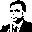

In [8]:
Image("training.jpeg")

In [18]:
class Model():
    def __init__(self, args, infer=False):
        self.args = args
        #if infer:
        #    '''Infer is true when the model is used for sampling'''
        #    args.seq_length = 1
   
        hidden_size = args.rnn_size
        vector_size = 2 # for B & W
        
        # define place holder to for the input data and the target.
        self.input_data = tf.placeholder(tf.float32, [ args.seq_length, vector_size], name='input_data')
        self.target_data = tf.placeholder(tf.float32, [ args.seq_length, vector_size], name='target_data') 
        # define the input xs
        xs = tf.split(0, args.seq_length, self.input_data)
        # define the target
        targets = tf.split(0, args.seq_length, self.target_data)  
        #initial_state
        self.initial_state = tf.zeros((hidden_size,1))
        
        # model parameters
        Wxh = tf.Variable(tf.random_uniform((hidden_size, vector_size))*0.01, name='Wxh') # input to hidden
        Whh = tf.Variable(tf.random_uniform((hidden_size, hidden_size))*0.01, name='Whh') # hidden to hidden
        Why = tf.Variable(tf.random_uniform((vector_size, hidden_size))*0.01, name='Why') # hidden to output
        bh = tf.Variable(tf.zeros((hidden_size, 1)), name='bh') # hidden bias
        by = tf.Variable(tf.zeros((vector_size, 1)), name='by') # output bias
        loss = tf.zeros([1], name='loss')
        hs, ys, ps = {}, {}, {}
        
        hs[-1] = self.initial_state
        # forward pass                                                                                                                                                                              
        for t in xrange(args.seq_length):
            xs_t = tf.transpose(xs[t])
            if infer and t>0: # to goes in generative mode
                xs_t = ps[t-1] # use the previous prediction instead of of the training data
           
            targets_t = tf.transpose(targets[t])
            
            hs[t] = tf.tanh(tf.matmul(Wxh, xs_t) + tf.matmul(Whh, hs[t-1]) + bh) # hidden state
            ys[t] = tf.matmul(Why, hs[t]) + by # unnormalized log probabilities for next pixel
            ps[t] = tf.exp(ys[t]) / tf.reduce_sum(tf.exp(ys[t])) # probabilities for next Pixel
            
            loss += -tf.log(tf.reduce_sum(tf.mul(ps[t], targets_t))) # softmax (cross-entropy loss)
            ps[t] = tf.tanh(1000.*ps[t]-500.)/2 + 0.5 
            
        self.probs = tf.pack([ps[key] for key in ps])
        self.cost = loss / args.seq_length
        self.final_state = hs[args.seq_length-1]
        self.lr = tf.Variable(0.0, trainable=False, name='learning_rate')
        tvars = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(tf.gradients(self.cost, tvars),
                args.grad_clip)
        optimizer = tf.train.AdamOptimizer(self.lr)
        self.train_op = optimizer.apply_gradients(zip(grads, tvars))
    
    def inspect(self, draw=False):
        for var in tf.all_variables():
            if var in tf.trainable_variables():
                print ('t', var.name, var.eval().shape)
                if draw:
                    plt.figure(figsize=(1,1))
                    plt.figimage(var.eval())
                    plt.show()
            else:
                print ('nt', var.name, var.eval().shape)
                
        

## Training

In [50]:
tf.reset_default_graph()
args = Args()
model = Model(args)
print ("model created")
faceloader = FaceLoader()
face_count = faceloader.prepare_reading_faces()
print ('faces count', face_count)

cost_optimisation = []

seq_length = args.seq_length
seq_count = (args.picture_size*args.picture_size)/args.seq_length


with tf.Session() as sess:
    tf.initialize_all_variables().run()
    print ("variable initialized")
    faceloader.do_when_session()
    saver = tf.train.Saver(tf.all_variables())

    # restore model
    if args.init_from is not None:
        ckpt = tf.train.get_checkpoint_state(args.init_from)
        assert ckpt,"No checkpoint found"
        assert ckpt.model_checkpoint_path,"No model path found in checkpoint"
        saver.restore(sess, ckpt.model_checkpoint_path)
        print ("model restored")
    for e in range(args.num_epochs):
        faceloader.image_reader.reset()
        sess.run(tf.assign(model.lr, args.learning_rate * (args.decay_rate ** e)))
        #state = model.initial_state.eval()
        faceloader.load_one_face(args.picture_size)
        for b in range(10000):
            start = time.time()
            # Get learning data
            #faceloader.load_one_face(args.picture_size)
            faceloader.create_batch(seq_length, seq_count)
            state = model.initial_state.eval()
            for l in range(1):
                x, y = faceloader.next_batch()
                # Create the structure for the learning data
                feed = {model.input_data: x, model.target_data: y, model.initial_state: state}
                # Run a session using train_op
                [train_loss], state, _ = sess.run([model.cost, model.final_state, model.train_op], feed)
                end = time.time()
            if (e * face_count + b) % args.print_every == 0:
                cost_optimisation.append(train_loss)
                print("{}/{} (epoch {}), train_loss = {:.6f}, time/batch = {:.3f}" \
                    .format(e * face_count + b,
                            args.num_epochs * face_count,
                            e, train_loss, end - start))
            if (e * face_count + b) % args.save_every == 0:
                checkpoint_path = os.path.join(args.save_dir, 'model.ckpt')
                saver.save(sess, checkpoint_path, global_step = e * face_count + b)
                print("model saved to {}".format(checkpoint_path))
                np.save('cost', cost_optimisation)


model created
('faces count', 16)
variable initialized
model restored
0/16 (epoch 0), train_loss = 0.000257, time/batch = 1.180
model saved to save_face_training_0.4/model.ckpt
10/16 (epoch 0), train_loss = 0.000255, time/batch = 0.324
20/16 (epoch 0), train_loss = 0.000253, time/batch = 0.322
30/16 (epoch 0), train_loss = 0.000250, time/batch = 0.319
40/16 (epoch 0), train_loss = 0.000248, time/batch = 0.306
50/16 (epoch 0), train_loss = 0.000246, time/batch = 0.316
60/16 (epoch 0), train_loss = 0.000243, time/batch = 0.314
70/16 (epoch 0), train_loss = 0.000241, time/batch = 0.329
80/16 (epoch 0), train_loss = 0.000239, time/batch = 0.309
90/16 (epoch 0), train_loss = 0.000237, time/batch = 0.307
100/16 (epoch 0), train_loss = 0.000235, time/batch = 0.313
model saved to save_face_training_0.4/model.ckpt
110/16 (epoch 0), train_loss = 0.000232, time/batch = 0.323
120/16 (epoch 0), train_loss = 0.000230, time/batch = 0.315
130/16 (epoch 0), train_loss = 0.000228, time/batch = 0.336
140

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


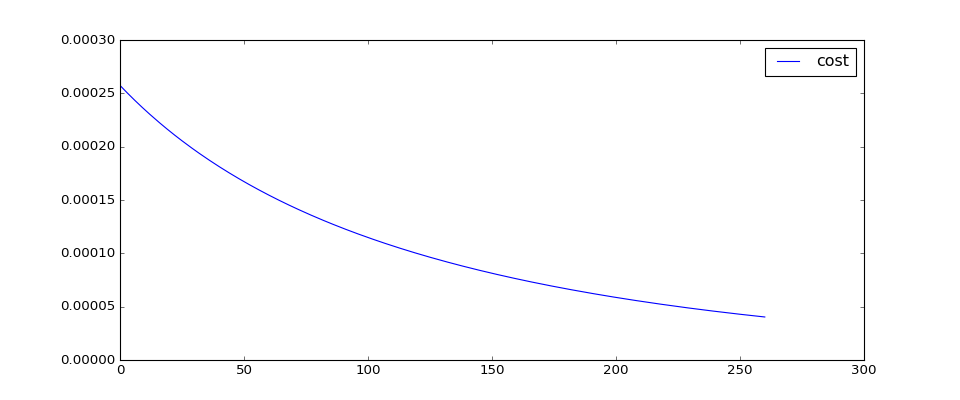

In [51]:
cost_optimisation = np.load('cost.npy')
plt.figure(figsize=(12,5))
plt.plot(range(len(cost_optimisation)), cost_optimisation, label='cost')
plt.legend()
plt.show()

In [ ]:
tf.reset_default_graph()
args = Args()
model = Model(args, True)  # True to generate the model in sampling mode
with tf.Session() as sess:
    tf.initialize_all_variables().run()
    saver = tf.train.Saver(tf.all_variables())
    ckpt = tf.train.get_checkpoint_state(args.save_dir)
    print (ckpt)
    
    model.inspect(draw=True)

## sampling

intialisation done
model_checkpoint_path: "save_face_training_0.4/model.ckpt-2600"
all_model_checkpoint_paths: "save_face_training_0.4/model.ckpt-2200"
all_model_checkpoint_paths: "save_face_training_0.4/model.ckpt-2300"
all_model_checkpoint_paths: "save_face_training_0.4/model.ckpt-2400"
all_model_checkpoint_paths: "save_face_training_0.4/model.ckpt-2500"
all_model_checkpoint_paths: "save_face_training_0.4/model.ckpt-2600"



<IPython.core.display.Javascript object>


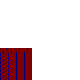

In [105]:
tf.reset_default_graph()
args = Args()
model = Model(args, infer=True)
seq_length = args.seq_length
seq_count = (args.picture_size*args.picture_size)/args.seq_length
with tf.Session() as sess:
    tf.initialize_all_variables().run()
    print 'intialisation done'
    saver = tf.train.Saver(tf.all_variables())
    ckpt = tf.train.get_checkpoint_state(args.save_dir)
    print (ckpt)
    
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
               
    state = model.initial_state.eval()
    x = np.random.random([seq_length, 2])
    
    pict = np.zeros([seq_count, seq_length])
    for i in range(seq_count):
        feed = {model.input_data: x, model.initial_state: state}
        [lines] = sess.run([model.probs], feed)
        x = np.squeeze(lines)
        #print x
        for j in range(seq_length):
            if x[j][0] > x[j][1]:
                pict[i][j] = 0
            else:
                pict[i][j] = 1
    picture = np.reshape(pict,[args.picture_size*args.picture_size])
    picture = np.reshape(pict,[args.picture_size,args.picture_size])
    plt.figure(figsize=(1,1))
    plt.figimage(picture)
    plt.show()


In [106]:
print picture

[[ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 ..., 
 [ 0.  1.  1. ...,  1.  1.  1.]
 [ 0.  1.  1. ...,  1.  1.  1.]
 [ 0.  1.  1. ...,  1.  1.  1.]]


In [107]:
from PIL import Image as Img
im = Img.fromarray((picture * 255).astype(np.uint8))
im.save("result.jpeg")

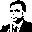

In [108]:
Image("training.jpeg")

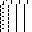

In [109]:
Image("result.jpeg")

[[   0.    0.    0. ...,    0.    0.    0.]
 [   0.    0.    0. ...,    0.    0.    0.]
 [   0.    0.    0. ...,    0.    0.    0.]
 ..., 
 [ 896.  896.  896. ...,  896.  896.  896.]
 [ 896.  896.  896. ...,  896.  896.  896.]
 [ 896.  896.  896. ...,  896.  896.  896.]]


<IPython.core.display.Javascript object>


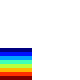

In [110]:
x = np.linspace(1, 100, num=100)
x = np.reshape(x, [10,10])
#print x

pict = np.zeros([32/4, 32*4])
for i in range(32/4):
    line = np.linspace(1, 32*4, num=32*4)
    
    for j in range(32*4):
        pict[i][j]=line[j]+i*32*4
        pict[i][j]=i*32*4

picture = np.reshape(pict,[32*32])
picture = np.reshape(pict,[32,32])
print picture
plt.figure(figsize=(1,1))
plt.figimage(picture)
plt.show()

Feedback wellcome __@dh7net__